In [1]:
# Math Operations
import numpy as np
from math import pi

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
!pip install soccerplots
import soccerplots
from soccerplots.radar_chart import Radar   # for custom radar visuals

# Machine Learning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Print Statement
print('All necessary libraries imported.')

All necessary libraries imported.


In [2]:
path = 'C:/Users/user/Desktop/xg-data-analysis/datasets/cleanedAdvanced'
extension = 'csv'
os.chdir(path)
result = glob.glob('*firstseason-allmerged.{}'.format(extension))

In [3]:
result

['brighton-firstseason-allmerged.csv',
 'huddersfield-firstseason-allmerged.csv',
 'leeds-firstseason-allmerged.csv',
 'newcastle-firstseason-allmerged.csv',
 'sheffutd-firstseason-allmerged.csv',
 'villa-firstseason-allmerged.csv',
 'wolves-firstseason-allmerged.csv']

In [4]:
bri_all = pd.read_csv(result[0])
hudds_all = pd.read_csv(result[1])
leeds_all = pd.read_csv(result[2])
newcastle_all = pd.read_csv(result[3])
sheffutd_all = pd.read_csv(result[4])
villa_all = pd.read_csv(result[5])
wolves_all = pd.read_csv(result[6])

In [5]:
result = pd.concat([hudds_all, leeds_all, newcastle_all, sheffutd_all, villa_all, wolves_all, bri_all])
result.shape

(165, 109)

In [6]:
result = result[~result['Player'].isin(["Squad Total", "Opponent Total"])]

In [7]:
result.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,55,40,13,2,19,45,...,0,2,4,0.11,4,0,0,0,0,0
1,Christopher Schindler,de GER,DF,27.0,83,56,27,0,24,41,...,0,2,1,0.03,1,0,0,0,0,0
2,Aaron Mooy,au AUS,MF,26.0,102,39,51,12,23,55,...,0,2,7,0.21,5,2,0,0,0,0
3,Jonathan Hogg,eng ENG,MF,28.0,93,29,59,5,26,89,...,3,1,1,0.04,0,0,0,0,1,0
4,Tom Ince,eng ENG,MFFW,25.0,35,14,16,5,10,29,...,5,1,2,0.07,1,0,0,1,0,0


In [8]:
result.shape

(158, 109)

In [9]:
## first take players who only played approx 25% of available mins
result = result[result['Min'] >= 800]
result.shape

(106, 109)

In [10]:
## check for nulls
features_with_na = [features for features in result.columns if result[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(result[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

Min/Start 0.4528 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
Min/Sub 0.5755 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
TeamSuccessOn-Off 0.0377 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
xG-On-Off 0.0377 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
SoT% 0.0094 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
G/Sh 0.0094 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
G/SoT 0.0849 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
Dist 0.0094 % missing values
['Min/Start', 'Min/S

In [11]:
result.fillna(0, inplace=True)

### Clustering Based on Defenders for First Season
This will allow us to see what similarities/differences there are between the performance levels in the first season at each of the clubs in questions. As already stated the majority of clubs here had far stronger second seasons than first seasons so it will be interesting to see any similarities in performance levels.

In [12]:
#result_def = result[result['Pos'].str.contains("DF")]
defender = ['DF', 'DFMF']
## subset those who are primarily defenders not midfielders who only sporadically play defense
result_def = result[result['Pos'].isin(defender)]

In [13]:
result_def.shape

(43, 109)

In [14]:
per_90_cols = [col for col in result_def.columns if '90' in col]
print(per_90_cols)

['Goals+/-90', 'xG+/-90', 'Sh/90', 'SoT/90', 'SCA90', 'GCA90']


### Need to Standardise our Columns creating a per 90 value for numeric columns without a per 90 value

In [15]:
keep = ["MediumCmp%", "LongCmp%", "ShortCmp%", "AerialDuelWon%",
       "Player", "Pos", "Age", "Nation", "CrdY", "CrdR"]
cols_change = ['Fls', 'Crs', 'Interceptions', 'TklWon', 'Recov','AerialDuelWon', "ProgressiveDist" "TotDist",
               "Assists","xAG","xA","A-xAG","KeyPasses","CompletedFinalThird",
           "PassesPenaltyArea","CrossesPA","ProgressivePasses",
               "Gls","Sh","SoT","SoT%", "xG","npxG","npxG/Sh","G-xG","np:G-xG", "SCAPassLive","SCAPassDead", "SCADef",
               "GCA", "GCADef", 'Tkl', 'TklWon',
       'TacklesDef3rd', 'TacklesMid3rd', 'TacklesAtt3rd', 'VSDribblesTkl',
       'VSDribblesAtt', 'VSDribblesTkl%', 'VSDribblesPast', 'Blocks',
       'ShotBlock', 'PassBlock', 'Interceptions', 'Tkl+Int', 'Clearances',
       'Errors']

In [16]:
not_needed = ["Gls","Sh","SoT","SoT%", "xG","npxG","npxG/Sh","G-xG","np:G-xG", "SCAPassLive","SCAPassDead",
                    "SCADrib", "SCASh", "SCAFld", "SCADef", "PassesPenaltyArea","CrossesPA", "xAG","xA",
             "GCAPassLive","GCAPassDead","GCADrib",
                    "GCASh", "GCAFld", "GCAPassLive","GCAPassDead","GCADrib",
                    "GCASh", "GCAFld"]

In [17]:
for column in result_def:
    if column in cols_change and column not in per_90_cols:
        result_def[column] = (result_def[column] / result_def['Min']) * 90
    else:
        continue

C:\Users\user\AppData\Local\Temp/ipykernel_17732/3331863228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_def[column] = (result_def[column] / result_def['Min']) * 90


In [18]:
result_def.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,1.447368,1.052632,0.342105,0.052632,0.500000,1.184211,...,0,0.052632,0.105263,0.11,4,0,0,0,0,0.0
1,Christopher Schindler,de GER,DF,27.0,2.287902,1.543645,0.744257,0.000000,0.661562,1.130168,...,0,0.055130,0.027565,0.03,1,0,0,0,0,0.0
6,Tommy Smith,eng ENG,DF,25.0,1.796218,0.850840,0.661765,0.283613,1.087185,1.701681,...,0,0.094538,0.094538,0.09,2,0,0,0,0,0.0
8,Florent Hadergjonaj,xk KVX,DFMF,23.0,1.129032,0.376344,0.537634,0.215054,0.645161,1.612903,...,1,0.000000,0.053763,0.05,1,0,0,0,0,0.0
9,Chris LÃ¶we,de GER,DF,28.0,2.437028,1.473552,0.850126,0.113350,1.133501,2.493703,...,2,0.113350,0.113350,0.11,1,1,0,0,0,0.0


In [19]:
all_cols_vals = keep + cols_change

In [20]:
result_def = result_def[result_def.columns[result_def.columns.isin(all_cols_vals)]]

In [21]:
result_def.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,xG,npxG,npxG/Sh,G-xG,np:G-xG,SCAPassLive,SCAPassDead,SCADef,GCA,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,1.447368,1.052632,0.342105,0.052632,0.500000,1.184211,...,0.050000,0.050000,0.003947,-0.050000,-0.050000,0.421053,0.026316,0.052632,0.105263,0.0
1,Christopher Schindler,de GER,DF,27.0,2.287902,1.543645,0.744257,0.000000,0.661562,1.130168,...,0.030322,0.030322,0.003032,-0.030322,-0.030322,0.358346,0.000000,0.055130,0.027565,0.0
6,Tommy Smith,eng ENG,DF,25.0,1.796218,0.850840,0.661765,0.283613,1.087185,1.701681,...,0.009454,0.009454,0.000945,-0.009454,-0.009454,1.323529,0.189076,0.094538,0.094538,0.0
8,Florent Hadergjonaj,xk KVX,DFMF,23.0,1.129032,0.376344,0.537634,0.215054,0.645161,1.612903,...,0.016129,0.016129,0.001613,-0.016129,-0.016129,1.827957,0.215054,0.000000,0.053763,0.0
9,Chris LÃ¶we,de GER,DF,28.0,2.437028,1.473552,0.850126,0.113350,1.133501,2.493703,...,0.022670,0.022670,0.002267,-0.022670,-0.022670,0.510076,0.340050,0.113350,0.113350,0.0


In [22]:
result_def = result_def[result_def.columns[~result_def.columns.isin(not_needed)]]
result_def.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,ShortCmp%,MediumCmp%,LongCmp%,Assists,A-xAG,KeyPasses,CompletedFinalThird,ProgressivePasses,GCA,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,1.447368,1.052632,0.342105,0.052632,0.500000,1.184211,...,86.2,83.7,51.1,0.052632,0.028947,0.236842,2.500000,2.500000,0.105263,0.0
1,Christopher Schindler,de GER,DF,27.0,2.287902,1.543645,0.744257,0.000000,0.661562,1.130168,...,87.3,87.1,57.8,0.027565,-0.035835,0.248086,1.488515,1.516080,0.027565,0.0
6,Tommy Smith,eng ENG,DF,25.0,1.796218,0.850840,0.661765,0.283613,1.087185,1.701681,...,86.8,70.8,37.0,0.047269,-0.037815,0.709034,2.127101,1.748950,0.094538,0.0
8,Florent Hadergjonaj,xk KVX,DFMF,23.0,1.129032,0.376344,0.537634,0.215054,0.645161,1.612903,...,84.5,63.6,39.3,0.053763,-0.026882,1.397849,2.204301,3.118280,0.053763,0.0
9,Chris LÃ¶we,de GER,DF,28.0,2.437028,1.473552,0.850126,0.113350,1.133501,2.493703,...,86.7,73.0,41.6,0.000000,-0.022670,0.283375,2.607053,1.983627,0.113350,0.0


### PCA / ML

Here we will take a clustering approach to compare how defenders playing a minimum of 800 minutes compared across the different teams in their respective first seasons in the Premier League. This can allow us to compare different styles of play and see was there any clear differences in style between the teams in how they defended. Teams like Huddersfield Town played a more conservative style of play while Leeds United played an aggressive (and some would say naive) man-to-man defensive system relying on individual duels.

### Defensive Clustering

In [23]:
numeric_def_s1 = result_def.iloc[:, 4:]

In [24]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
x = numeric_def_s1.values    # NumPy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [25]:
X_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.351038,0.388698,0.243631,0.179898,0.221066,0.306139,0.032435,0.409704,0.562332,0.294296,...,0.507937,0.670000,0.556122,0.367719,0.924519,0.123325,0.407938,0.494918,0.367719,0.0
1,0.651453,0.656947,0.637007,0.000000,0.336791,0.284956,0.138405,0.260282,0.700262,0.489532,...,0.595238,0.783333,0.727041,0.192588,0.602650,0.129180,0.140545,0.190151,0.096294,0.0
2,0.475720,0.278456,0.556315,0.969407,0.641660,0.508968,0.435592,0.361389,0.389395,0.136683,...,0.555556,0.240000,0.196429,0.330252,0.592810,0.369199,0.309360,0.262282,0.330252,0.0
3,0.237261,0.019230,0.434893,0.735066,0.325044,0.474170,0.251962,0.606202,0.488407,0.301646,...,0.373016,0.000000,0.255102,0.375627,0.647133,0.727870,0.329768,0.686428,0.187814,0.0
4,0.704752,0.618654,0.740566,0.387437,0.674836,0.819411,0.342343,0.878192,0.493522,0.246944,...,0.547619,0.313333,0.313776,0.000000,0.668058,0.147556,0.436239,0.334973,0.395970,0.0


In [26]:
pca = PCA()
pca.fit(X_norm)

PCA()

([<matplotlib.axis.XTick at 0x1cde31014f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

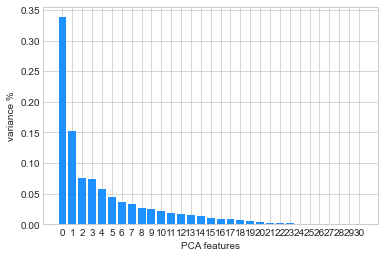

In [27]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'dodgerblue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [28]:
pca_2d = PCA(n_components = 2)

# Save components to a DataFrame
df_reduced = pd.DataFrame(pca_2d.fit_transform(X_norm))

In [29]:
df_reduced.head()

,0,1
0,-0.334361,-0.113652
1,-0.652224,0.674840
2,0.588164,-0.364263
3,0.712761,-1.027355
4,0.769425,0.220850


C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


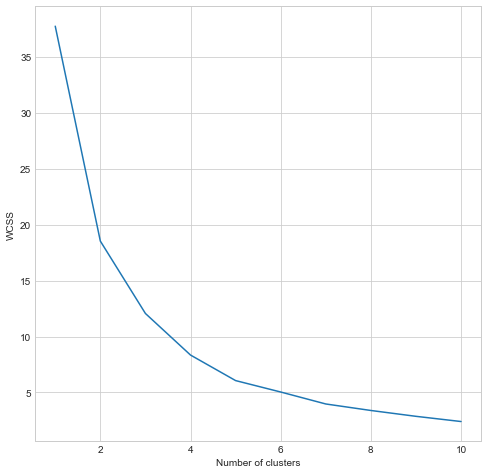

In [30]:
wcss = []

for i in range(1,11):
    model = KMeans(n_clusters = i, init = "k-means++", max_iter = 600, random_state = 42)
    model.fit(df_reduced)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [31]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
for n in range(2, 11):
    km = KMeans(n_clusters=n)
#
# Fit the KMeans model
# Have to pick subset of columns as Study column is in string format
    km.fit_predict(df_reduced)
#
# Calculate Silhoutte Score
#
    score = silhouette_score(df_reduced, km.labels_, metric='euclidean')
#
# Print the score
#
    print('N = ' + str(n) + ' Silhouette Score: %.3f' % score)

N = 2 Silhouette Score: 0.432
N = 3 Silhouette Score: 0.431
N = 4 Silhouette Score: 0.395
N = 5 Silhouette Score: 0.409
N = 6 Silhouette Score: 0.411
N = 7 Silhouette Score: 0.433
N = 8 Silhouette Score: 0.429
N = 9 Silhouette Score: 0.389
N = 10 Silhouette Score: 0.437


In [32]:
# K-Means Clustering

## Specify the number of clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 600, random_state = 42)

## Fit the input data
kmeans = kmeans.fit(df_reduced)

## Get the cluster labels
labels = kmeans.predict(df_reduced)

## Centroid values
centroid = kmeans.cluster_centers_

## Cluster values
clusters = kmeans.labels_.tolist()

In [33]:
x_coord = df_reduced[0].tolist()
y_coord = df_reduced[1].tolist()
result_def['X'] = x_coord
result_def['Y'] = y_coord
result_def['Cluster'] = clusters

C:\Users\user\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


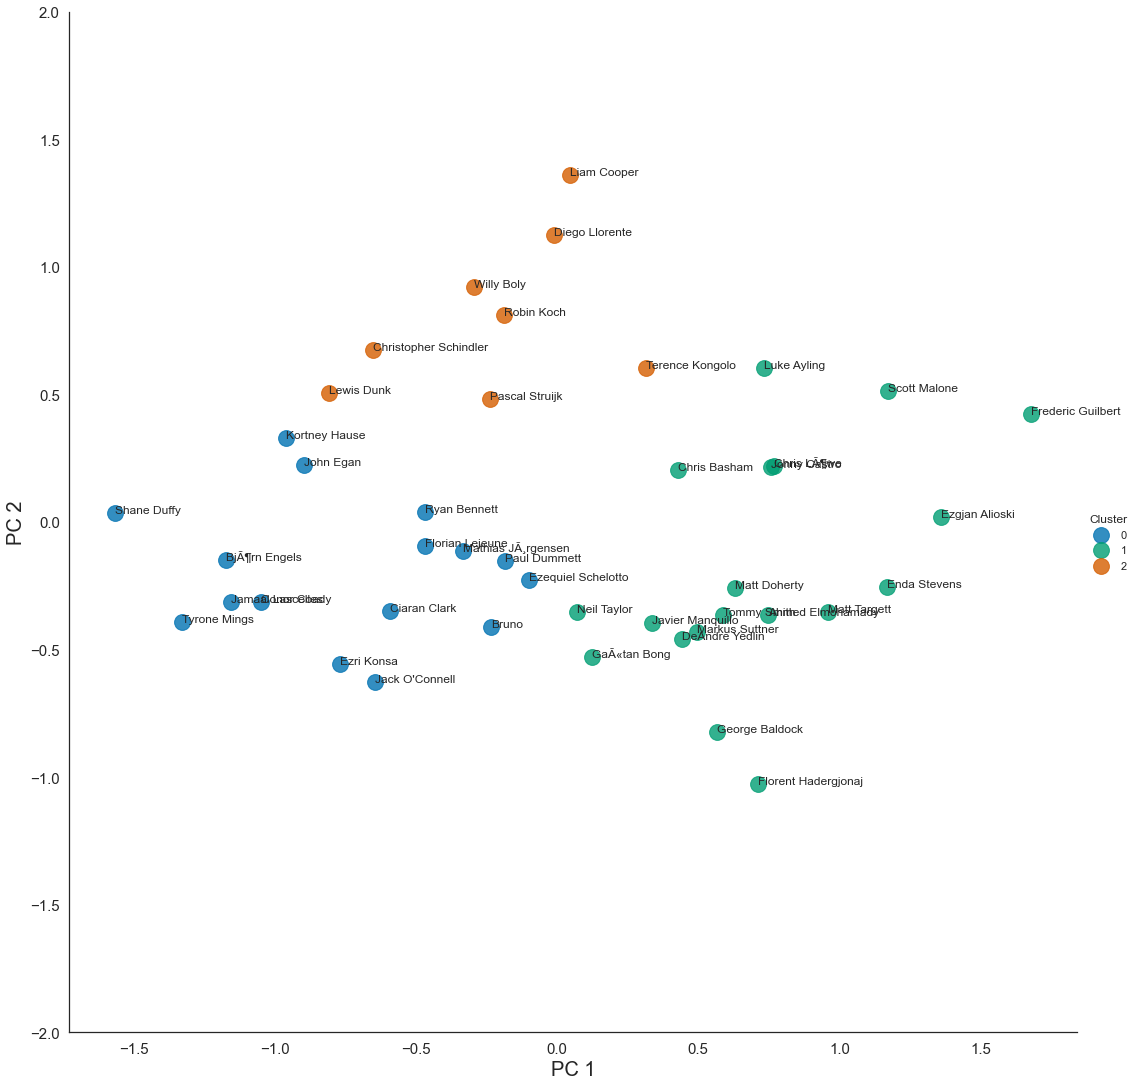

In [34]:
# Visualise the clustering
sns.set(style = 'white')
plt.style.use('seaborn-colorblind') 
ax = sns.lmplot(x = "X", y = "Y", hue = 'Cluster', data = result_def, legend = True,
fit_reg = False, size = 15, scatter_kws = {"s": 250})
texts = []
for x, y, s in zip(result_def.X, result_def.Y, result_def.Player):
    texts.append(plt.text(x, y, s))
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize = 15)
plt.xlabel('PC 1', fontsize = 20)
plt.ylabel('PC 2', fontsize = 20)
plt.show()

### Defensive Clustering Findings
The cluster to the right in green focuses on full backs predominately, with no pattern amongst teams with stronger/weaker first seasons. The top cluster in orange does have an interesting trend of containing players who are only centre backs and who play for Leeds, Wolves and Huddersfield only. This would potentially suggest these players defended in a similar manner and/or showed similar performance levels across their first seasons. This will be something we will be checking for to see if these players can be seen in the same clusters for their second season. Wolves and Leeds both performed very strongly in their first seasons and the fact their centre backs share the same clusters suggests that had both had strong seasons based on the metrics we are measuring them on here. Lastly, the green cluster mainly contains centre backs from Newcastle, Sheffield United, Brighton and Aston Villa. There are also prominent Wolves defenders Conor Coady and Ryan Bennett. It is worth noting the difference in distance these players have from their team mates Romain Saiss and Wily Boly (blue cluster). Saiss, a converted midfielder, and Boly show more desire to join attacks than Coady and Bennett and it maybe shows that Coady and Bennett are more conservative, safety first defenders. The fact Saiss and Boly are in clusters with all of Leeds United's centre backs, a team regarded in their first season as expansive and thrilling to watch would back this point up. This idea would hold up further as teams such as Brighton, Sheffield United and Newcastle who all have defenders in this cluster would be regarded as playing "safety first" football. Brighton's full backs Bruno and Ezequiel Scheletto appear in this centre back heavy cluster too which further illustrates the point. The orange clusters also highlight the similarity in the roles of a modern full back or wing back today. Full backs seem to have a much different role to centre backs based on the clusters and it is interesting to note the closeness of some full backs in this cluster when teams playing styles are taken into account.

### Attacking Clustering

In [35]:
result_att = result[result['Pos'].str.contains("FW")]
result_att.shape

(38, 109)

In [36]:
attacking_keep = ["Gls","Sh","SoT","SoT%", "xG","npxG","npxG/Sh","G-xG","np:G-xG", "SCAPassLive","SCAPassDead",
                    "SCADrib", "SCASh", "SCAFld", "SCADef", "PassesPenaltyArea","CrossesPA", "xAG","xA",
             "GCAPassLive","GCAPassDead","GCADrib",
                    "GCASh", "GCAFld", "GCAPassLive","GCAPassDead","GCADrib",
                    "GCASh", "GCAFld", "Assists","xAG","xA","A-xAG", "KeyPasses","CompletedFinalThird",
           "PassesPenaltyArea","CrossesPA","ProgressivePasses", "MediumCmp%", "LongCmp%", "ShortCmp%", "AerialDuelWon%",
       "Player", "Pos", "Age", "Nation"]

In [37]:
keep = ["MediumCmp%", "LongCmp%", "ShortCmp%", "AerialDuelWon%",
       "Player", "Pos", "Age", "Nation", "CrdY", "CrdR"]
cols_change = ['Fls', 'Crs', 'Interceptions', 'TklWon', 'Recov','AerialDuelWon', "ProgressiveDist" "TotDist",
               "Assists","xAG","xA","A-xAG","KeyPasses","CompletedFinalThird",
           "PassesPenaltyArea","CrossesPA","ProgressivePasses",
               "Gls","Sh","SoT","SoT%", "xG","npxG","npxG/Sh","G-xG","np:G-xG", "SCAPassLive","SCAPassDead", "SCADef",
               "GCA", "GCADef", 'Tkl', 'TklWon',
       'TacklesDef3rd', 'TacklesMid3rd', 'TacklesAtt3rd', 'VSDribblesTkl',
       'VSDribblesAtt', 'VSDribblesTkl%', 'VSDribblesPast', 'Blocks',
       'ShotBlock', 'PassBlock', 'Interceptions', 'Tkl+Int', 'Clearances',
       'Errors']

In [38]:
for column in result_att:
    if column in cols_change and column not in per_90_cols:
        result_att[column] = (result_att[column] / result_att['Min']) * 90
    else:
        continue

C:\Users\user\AppData\Local\Temp/ipykernel_17732/461334572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_att[column] = (result_att[column] / result_att['Min']) * 90


In [39]:
result_att = result_att[result_att.columns[result_att.columns.isin(attacking_keep)]]
result_att.head()

,Player,Nation,Pos,Age,AerialDuelWon%,ShortCmp%,MediumCmp%,LongCmp%,Assists,xAG,...,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld
4,Tom Ince,eng ENG,MFFW,25.0,27.1,87.8,84.3,35.4,0.000000,0.051387,...,0.183524,5,9,5,0.036705,1,0,0,1,0
5,Rajiv van La Parra,nl NED,FWMF,26.0,30.0,82.3,72.8,43.6,0.000000,0.037904,...,0.000000,8,4,6,0.000000,0,0,0,0,0
7,Steve MouniÃ©,bj BEN,FW,22.0,52.2,66.3,51.7,72.2,0.048518,0.087332,...,0.000000,3,4,2,0.000000,2,0,2,0,0
10,Laurent Depoitre,be BEL,FW,28.0,47.0,59.1,56.7,64.7,0.049451,0.069231,...,0.000000,3,3,3,0.049451,2,0,2,1,1
11,Elias Kachunga,cd COD,FWMF,25.0,32.7,76.9,60.7,29.4,0.067720,0.040632,...,0.000000,3,0,3,0.000000,1,0,0,0,0


### PCA of Attacking Players in First Season

In [40]:
numeric_att_s1 = result_att.iloc[:, 4:]

([<matplotlib.axis.XTick at 0x1cde4d0ef10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

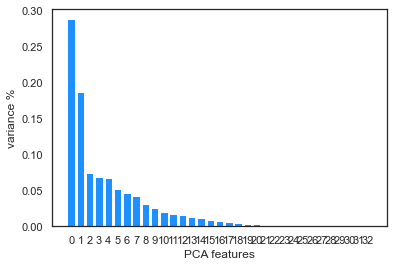

In [41]:
x = numeric_att_s1.values    # NumPy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)
pca = PCA()
pca.fit(X_norm)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'dodgerblue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [42]:
pca_2d = PCA(n_components = 2)

# Save components to a DataFrame
df_reduced = pd.DataFrame(pca_2d.fit_transform(X_norm))

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


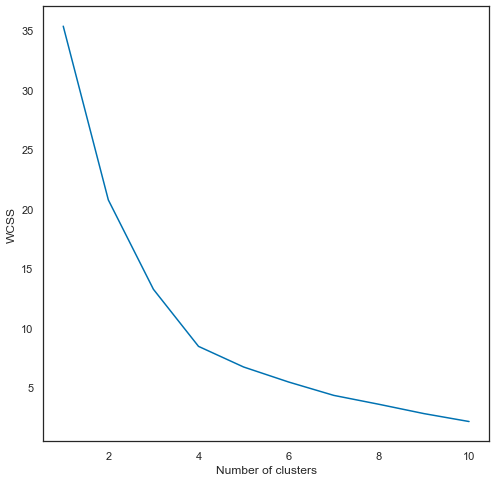

In [43]:
wcss = []

for i in range(1,11):
    model = KMeans(n_clusters = i, init = "k-means++", max_iter = 600, random_state = 42)
    model.fit(df_reduced)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [44]:
for n in range(2, 11):
    km = KMeans(n_clusters=n)
#
# Fit the KMeans model
# Have to pick subset of columns as Study column is in string format
    km.fit_predict(df_reduced)
#
# Calculate Silhoutte Score
#
    score = silhouette_score(df_reduced, km.labels_, metric='euclidean')
#
# Print the score
#
    print('N = ' + str(n) + ' Silhouette Score: %.3f' % score)

N = 2 Silhouette Score: 0.387
N = 3 Silhouette Score: 0.409
N = 4 Silhouette Score: 0.415
N = 5 Silhouette Score: 0.371
N = 6 Silhouette Score: 0.388
N = 7 Silhouette Score: 0.406
N = 8 Silhouette Score: 0.410
N = 9 Silhouette Score: 0.406
N = 10 Silhouette Score: 0.369


In [45]:
## Specify the number of clusters
## using two clusters as best silhouette score as per above
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 600, random_state = 42)

## Fit the input data
kmeans = kmeans.fit(df_reduced)

## Get the cluster labels
labels = kmeans.predict(df_reduced)

## Centroid values
centroid = kmeans.cluster_centers_

## Cluster values
clusters = kmeans.labels_.tolist()

C:\Users\user\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0, flags=flags)


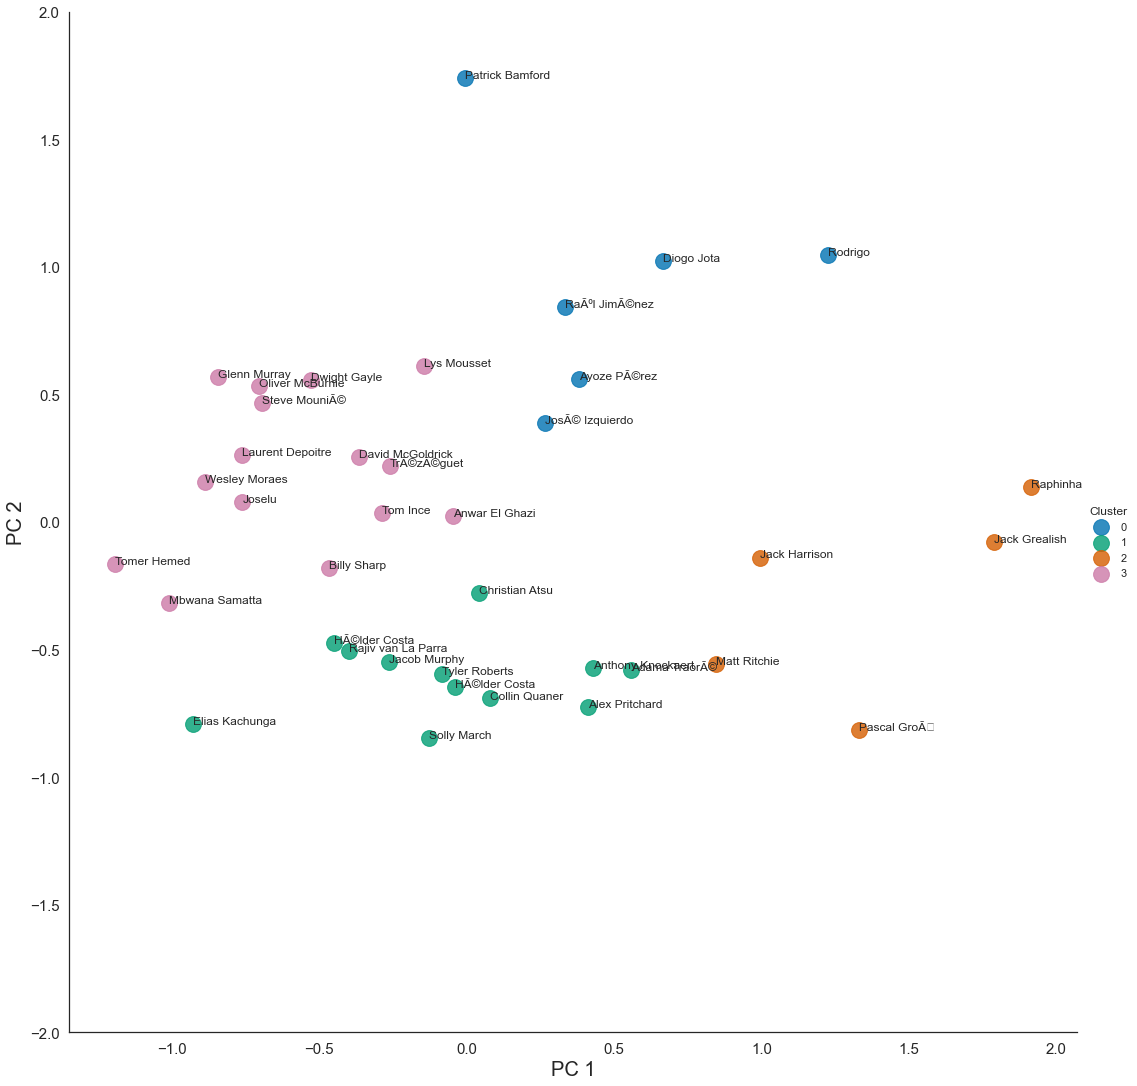

In [46]:
x_coord = df_reduced[0].tolist()
y_coord = df_reduced[1].tolist()
result_att['X'] = x_coord
result_att['Y'] = y_coord
result_att['Cluster'] = clusters
### graph
sns.set(style = 'white')
plt.style.use('seaborn-colorblind') 
ax = sns.lmplot(x = "X", y = "Y", hue = 'Cluster', data = result_att, legend = True,
fit_reg = False, size = 15, scatter_kws = {"s": 250})
texts = []
for x, y, s in zip(result_att.X, result_att.Y, result_att.Player):
    texts.append(plt.text(x, y, s))
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize = 15)
plt.xlabel('PC 1', fontsize = 20)
plt.ylabel('PC 2', fontsize = 20)
plt.show()

### Findings from our attacking clusters
It is quite interesting to note from this cluster looking at attacking players for season 1 that the cluster to the right contains exclusively players from clubs that had relatively/extremely strong first seasons with the exception of Jack Grealish (who would now be regarded as an elite level player anyway). It is interesting to note the difference in high performing wingers such as Raphinha and Jack Grealish who are grouped very closely together and who both had very strong individual seasons in their respective clubs first seasons in the Premier League. It also suggests that these players share very similar characteristics in the way that they play. The example of Jack Harrison being much further away from Grealish than Raphinha despite being in the same team would suggest that.